In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pdb

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL'):
    # Create a list to append feature vectors to
    features = []
    feature_image = np.copy(img)      

        # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)            
    return hog_features/np.linalg.norm(hog_features)

In [3]:
# HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [48]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, classifier, orient, pix_per_cell, cell_per_block):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float64)/255
    
    img_tosearch = img[ystart:ystop,:,:]    
    ctrans_tosearch = img_tosearch
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes = []
    window_cnt = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            window_cnt += 1
            
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #pdb.set_trace()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, 
                                      hog_feat2,
                                      hog_feat3))
        
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Scale features and make a prediction 
            test_features = hog_features/np.linalg.norm(hog_features)
            test_prediction = classifier.predict(test_features.reshape(1, -1))
            
            #pdb.set_trace()
            if test_prediction == 1:
                #pdb.set_trace()
                #cv2.imwrite('subimg.png',subimg)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    print('Windows: %d Detected cars: %d'%(window_cnt, len(boxes)))            
    return draw_img, boxes
    

Windows: 46 Detected cars: 2


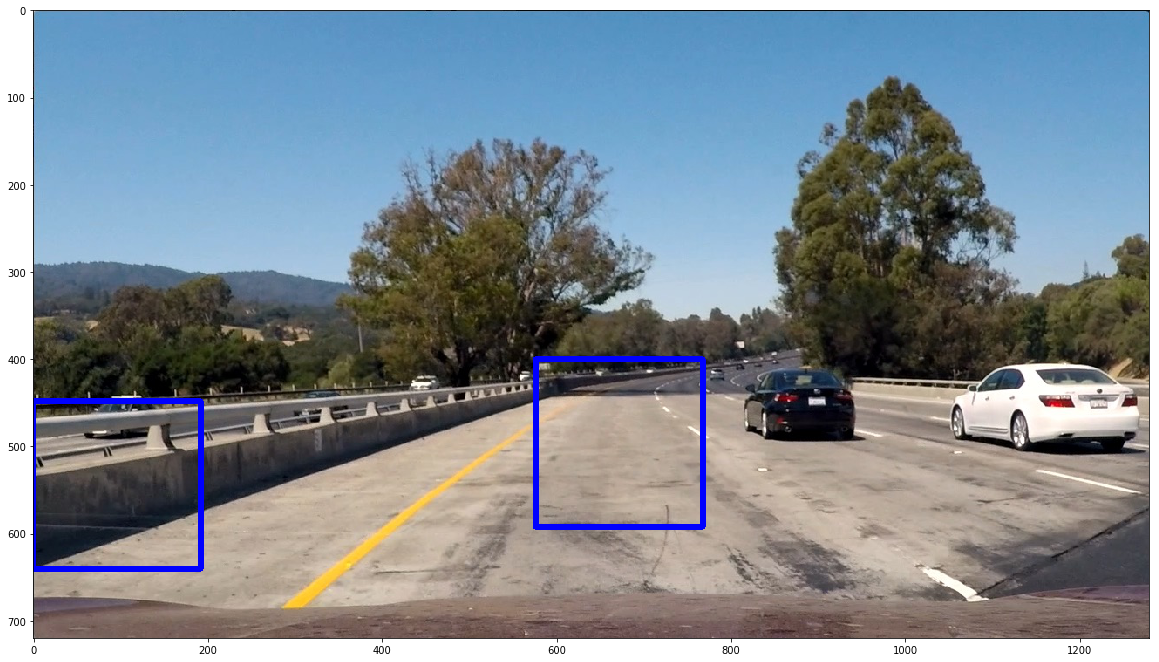

In [49]:
ystart = 400
ystop = 656
scale = 3

img = mpimg.imread('./test_images/test1.jpg')
#plt.figure(figsize=(20,20))
#plt.imshow(img)

# load Xgboost classifier model from file
#xgboost_model = pickle.load(open("normalized_xgboost_classifier_small.pkl", "rb"))
classifier_model = pickle.load(open("normalized_linearSVM_classifier.pkl", "rb"))

out_img, boxes = find_cars(img, ystart, ystop, scale, classifier_model, orient, pix_per_cell, cell_per_block)

plt.figure(figsize=(20,20))
plt.imshow(out_img)

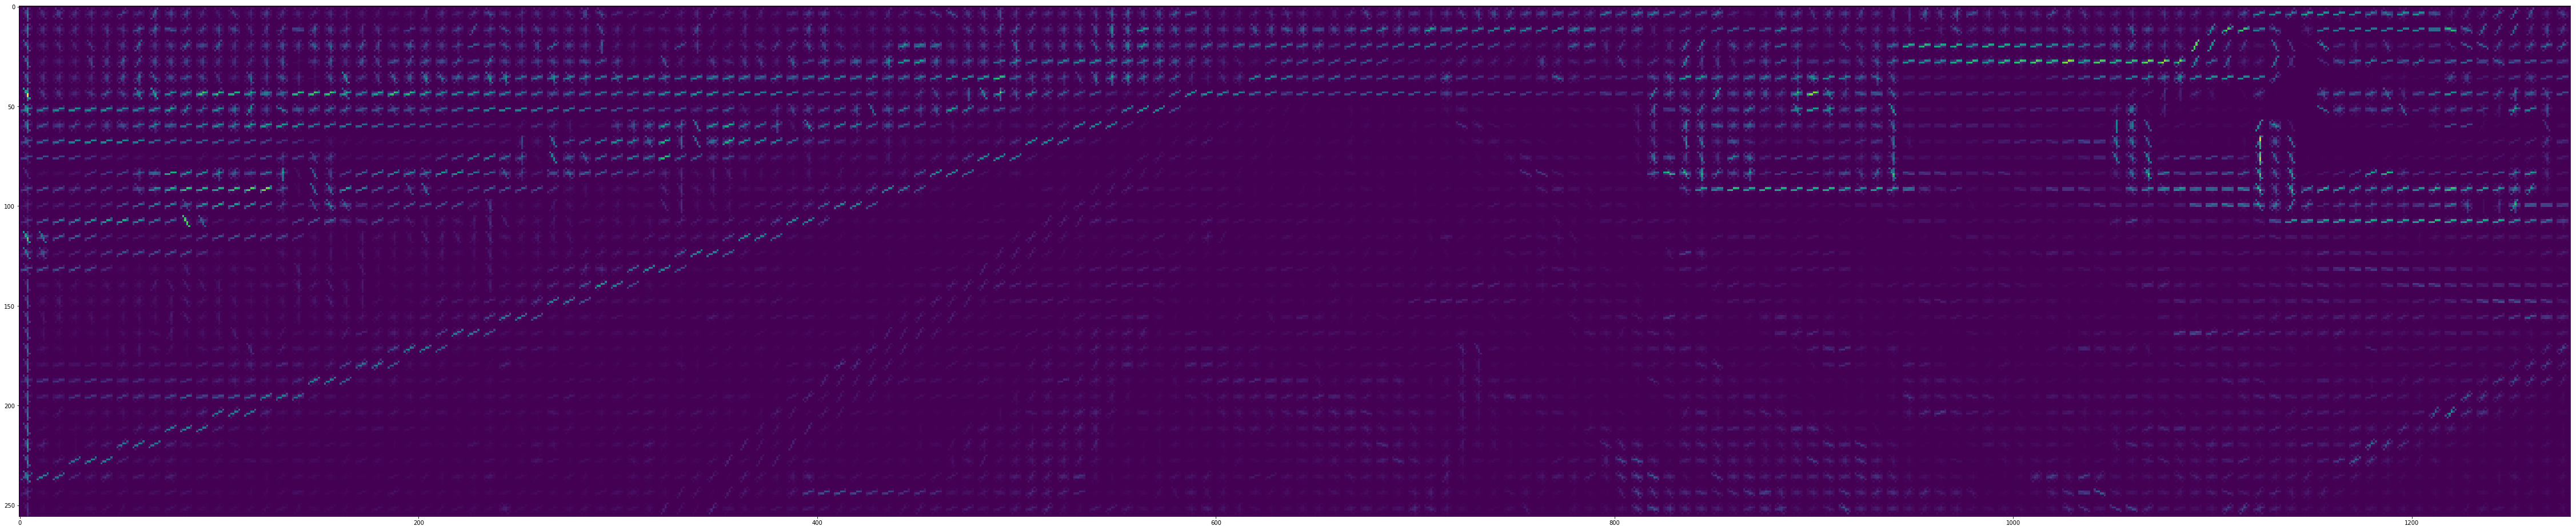

In [160]:
hog1, hog_fig = get_hog_features(img[ystart:ystop,:,0].astype(np.float64)/255, orient, pix_per_cell, cell_per_block, vis=True)
plt.figure(figsize=(80,40))
plt.imshow(hog_fig)

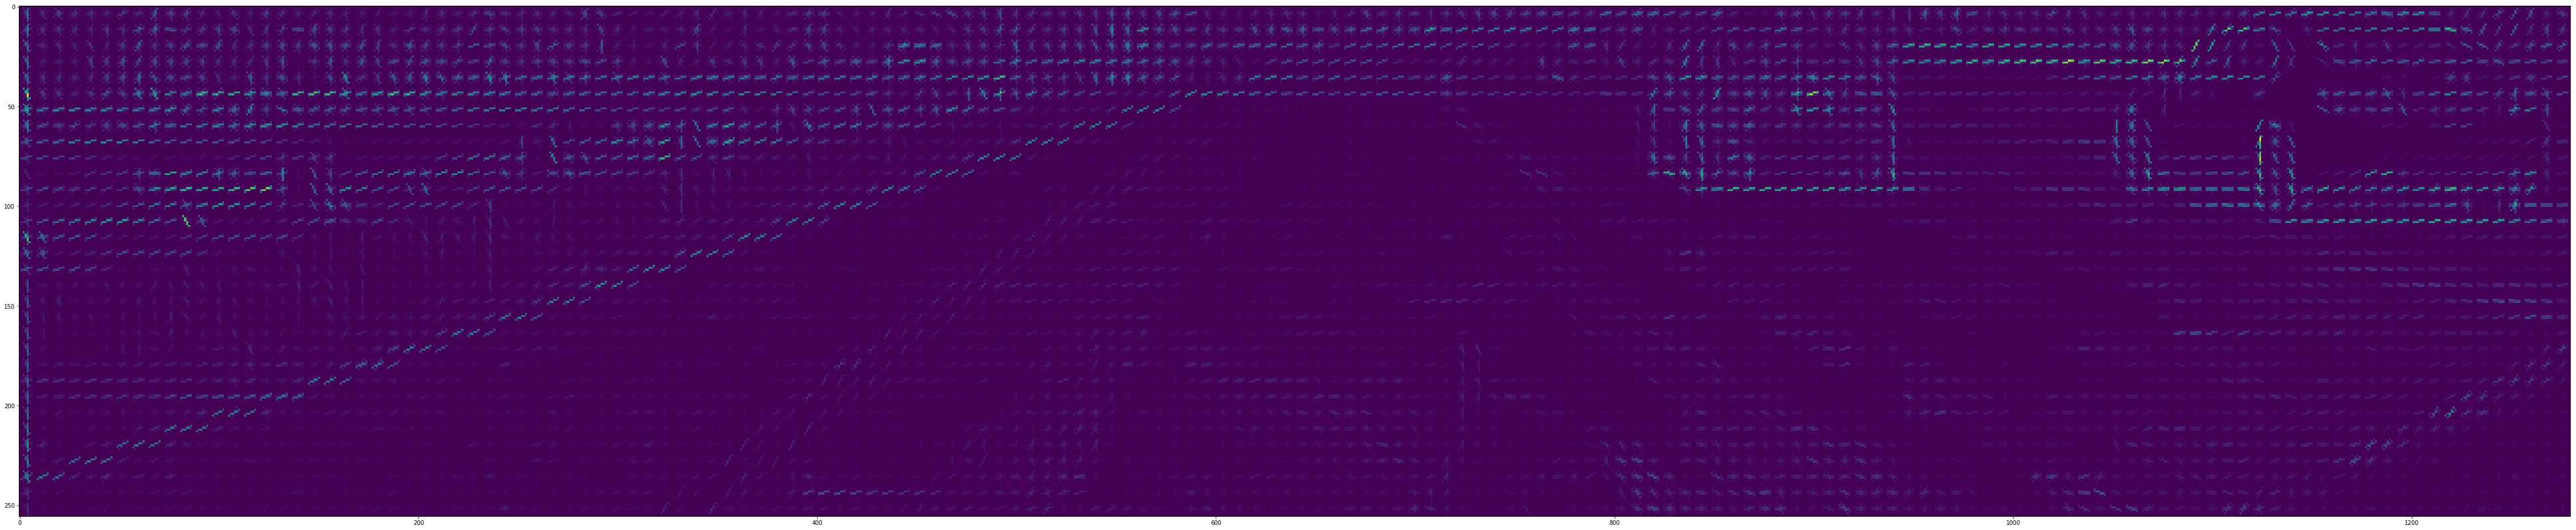

In [161]:
hog2, hog_fig2 = get_hog_features(img[ystart:ystop,:,0], orient, pix_per_cell, cell_per_block, vis=True)
plt.figure(figsize=(80,40))
plt.imshow(hog_fig2)

In [164]:
np.mean(hog1)

8.993148497113093

In [165]:
np.mean(hog2)

0.5645380750383603

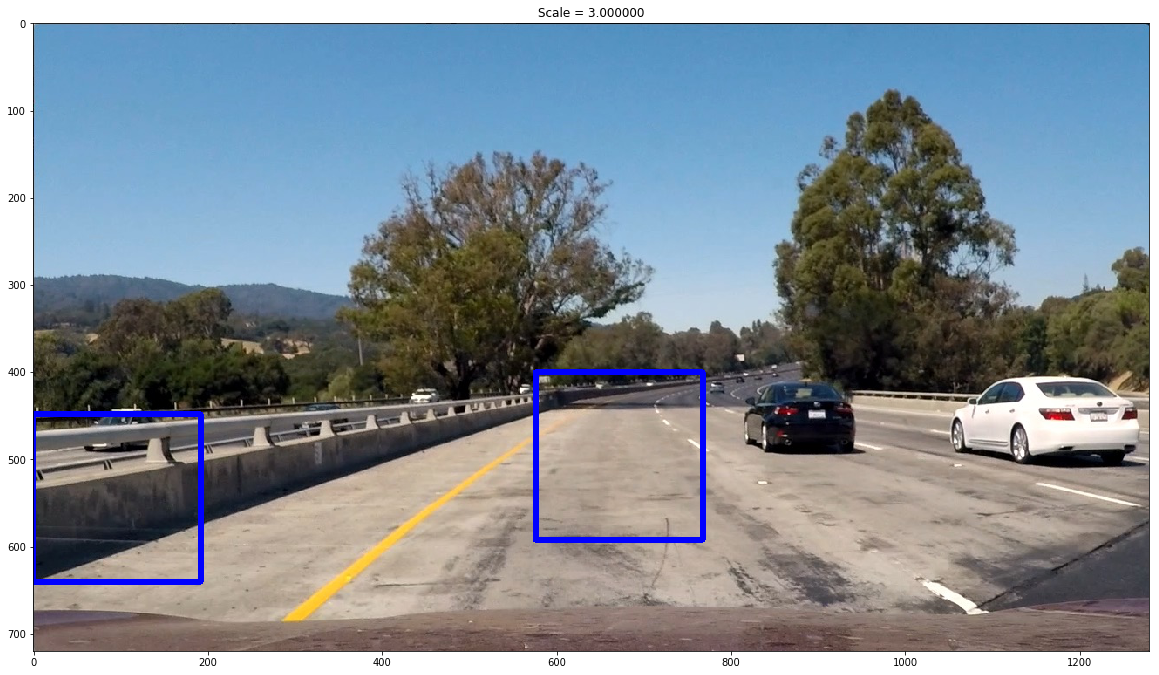

In [18]:
ystart = 400
ystop = 656

boxes = []
for scale in  [3]: #np.arange(1, 5, 1):    
    out_img, box = find_cars(img, ystart, ystop, scale, classifier_model, orient, pix_per_cell, cell_per_block)
    boxes.extend(box)
    plt.figure(figsize=(20,20))
    plt.title('Scale = %f'%scale)
    plt.imshow(out_img)

True

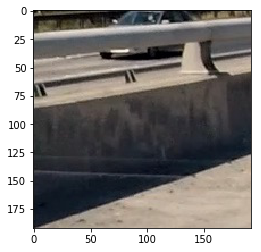

In [29]:
box0 = box[0]
plt.imshow(img[box0[0][1]:box0[1][1], box0[0][0]:box0[1][0], :] )
cv2.imwrite('subimg.png',img[box0[0][1]:box0[1][1], box0[0][0]:box0[1][0], :])

In [24]:
subimg = cv2.resize(img[box0[0][1]:box0[1][1], box0[0][0]:box0[1][0], :], (64,64))

hog_features = extract_features(subimg, orient, pix_per_cell, cell_per_block)          
# Scale features and make a prediction
test_prediction = classifier_model.predict(hog_features.reshape(1,-1))
print(test_prediction)

[1.]


In [28]:
np.linalg.norm(hog_features)

0.9999999999999998

[1.]


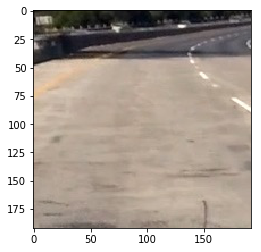

In [26]:
box0 = box[1]
plt.imshow(img[box0[0][1]:box0[1][1], box0[0][0]:box0[1][0], :] )
subimg = cv2.resize(img[box0[0][1]:box0[1][1], box0[0][0]:box0[1][0], :], (64,64))

hog_features = extract_features(subimg, orient, pix_per_cell, cell_per_block)          
# Scale features and make a prediction
test_prediction = classifier_model.predict(hog_features.reshape(1,-1))
print(test_prediction)

In [81]:
test_prediction == 1

array([False])

In [28]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

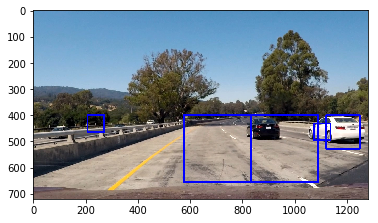

In [53]:
# Testing non-max supression
box_list = np.asarray([[box[0][0], box[0][1], box[1][0], box[1][1]] for box in boxes], dtype=np.float)
suppresed_boxes = non_max_suppression_fast(box_list, overlapThresh=0.4)
suppresed_boxes = [((box[0], box[1]),(box[2],box[3])) for box in suppresed_boxes ]
draw_img = img.copy()
for box in suppresed_boxes:
    cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6) 
plt.imshow(draw_img) 

In [30]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        font = cv2.FONT_HERSHEY_SIMPLEX
        #cv2.putText(img,'%d'%car_number,bbox[0], font, 4,(255,255,255),2,cv2.LINE_AA)
    # Return the image
    return img

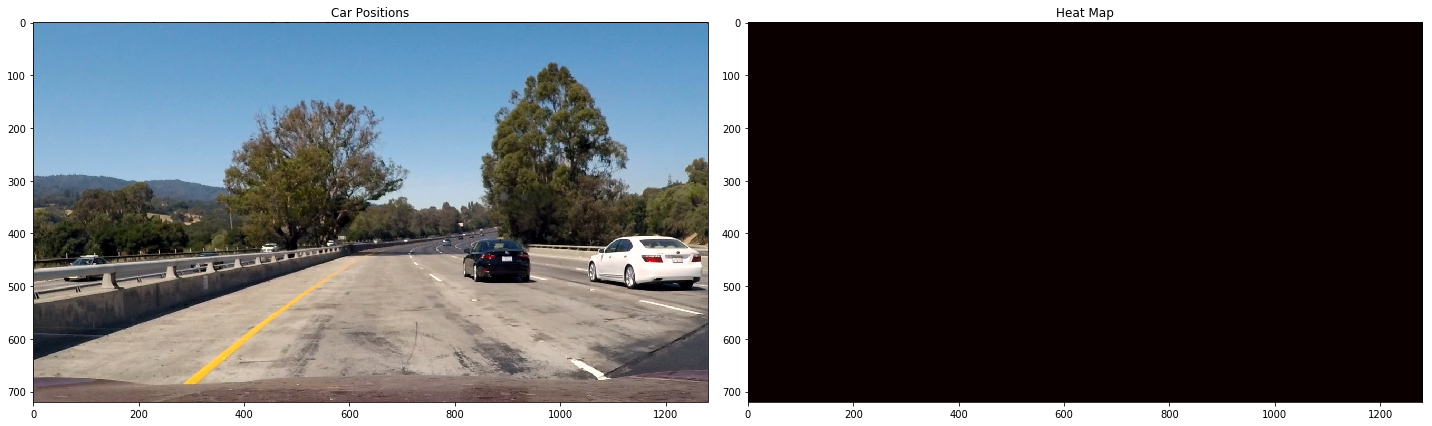

In [31]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [50]:
def car_detection_pipeline(img, xgboost_model, orient, pix_per_cell, cell_per_block):
    ystart = 400
    ystop = 656

    boxes = []
    for scale in  np.arange(1, 5, 1):    
        out_img, box = find_cars(img, ystart, ystop, scale, xgboost_model, orient, pix_per_cell, cell_per_block)
        boxes.extend(box)
    
    print(len(boxes))
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = heat*255/np.max(heat)
    heatmap = np.clip(heatmap, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    heatmap = np.dstack((heatmap, heatmap, heatmap))

    result = np.hstack((draw_img, heatmap))
    return result.astype(np.int32)

In [51]:
result = car_detection_pipeline(img, classifier_model, orient, pix_per_cell, cell_per_block)

Windows: 1001 Detected cars: 22
Windows: 185 Detected cars: 3
Windows: 46 Detected cars: 2
Windows: 17 Detected cars: 0
27


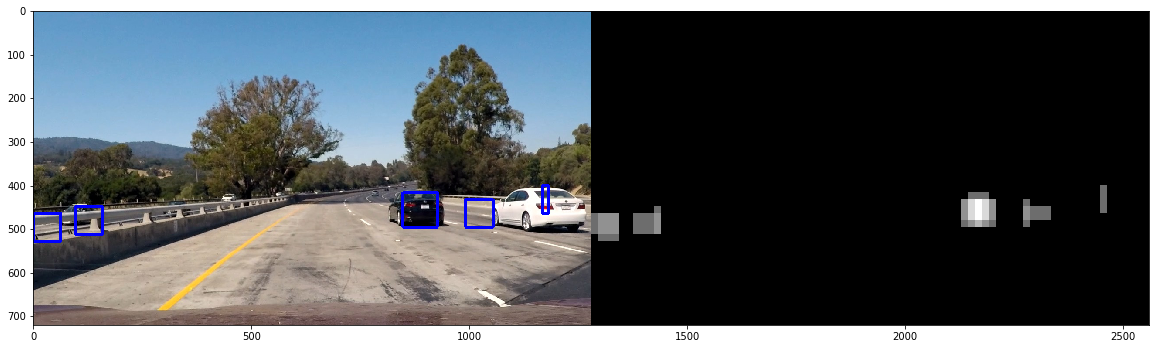

In [45]:
plt.figure(figsize=(20,20))
plt.imshow(result)

# Apply pipeline on video

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './test_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(lambda img: car_detection_pipeline(img, xgboost_model, X_scaler, orient, pix_per_cell, cell_per_block)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./test_video_proccessed.mp4
[MoviePy] Writing video ./test_video_proccessed.mp4


 97%|█████████▋| 38/39 [06:26<00:10, 10.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_proccessed.mp4 

CPU times: user 1h 7min 9s, sys: 18.7 s, total: 1h 7min 28s
Wall time: 6min 27s


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './project_video_proccessed.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(lambda img: car_detection_pipeline(img, xgboost_model, X_scaler, orient, pix_per_cell, cell_per_block)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_proccessed.mp4
[MoviePy] Writing video ./project_video_proccessed.mp4



  0%|          | 3/1261 [00:39<4:37:39, 13.24s/it]

In [ ]:
from lane_detection import detect_lane

detect_car = lambda img: car_detection_pipeline(img, xgboost_model, X_scaler, orient, pix_per_cell, cell_per_block)
result, out_img = 